In [1]:
import os, gc, torch, PIL, pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from data.dataset import ReflacxDataset
from data.dataset import collate_fn
from utils.transforms import get_transform
from utils.plot import  get_legend_elements, disease_cmap
from utils.pred import pred_thrs_check
from models.rcnn import get_model_instance_segmentation, get_multimodal_model_instance_segmentation

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

In [3]:
model_path_dict = {
    "custom": {
        "with_clinical": "val_ar_0_3909_ap_0_1828_test_ar_0_3808_ap_0_1542_epoch39_WithClincal_03-14-2022 17-14-52",
        "without_clinical": "val_ar_0_3410_ap_0_1753_test_ar_0_3553_ap_0_1832_epoch33_WithoutClincal_03-14-2022 19-10-27",
    },
    "original": {
        "with_clinical": None,
        "without_clinical": "val_ar_0_3000_ap_0_1542_test_ar_0_3504_ap_0_1386_epoch15_WithoutClincal_03-14-2022 03-10-11",
    },
}

def get_model_path(model_path_dict, use_custom_modal, use_clinical):

    final_model_path = model_path_dict["custom" if use_custom_modal else "original"][
        "with_clinical" if use_clinical else "without_clinical"
    ]

    return final_model_path


In [4]:
def plot_iou_result(model_path_dict, suffix):
    original_without_clinical_path = get_model_path(model_path_dict=model_path_dict, use_custom_modal=False, use_clinical=False)

    custom_without_clinical_path = get_model_path(model_path_dict=model_path_dict, use_custom_modal=True, use_clinical=False)

    custom_with_clinical_path = get_model_path(model_path_dict=model_path_dict, use_custom_modal=True, use_clinical=True)

    with open(os.path.join("eval_results", f"{original_without_clinical_path}_{suffix}.pkl"), 'rb') as f:
        original_without_clinical_ap_ar = pickle.load(f)

    with open(os.path.join("eval_results", f"{custom_without_clinical_path}_{suffix}.pkl"), 'rb') as f:
        custom_without_clinical_ap_ar = pickle.load(f)

    with open(os.path.join("eval_results", f"{custom_with_clinical_path}_{suffix}.pkl"), 'rb') as f:
        custom_with_clinical_ap_ar = pickle.load(f)

    fig, (precision_ax, recall_ax) = plt.subplots(
        2, figsize=(10, 10), dpi=80, sharex=True,
    )

    precision_ax.set_title("Average Precision")
    precision_ax.plot(
        original_without_clinical_ap_ar.keys(),
        [v[0]["ap"] for v in original_without_clinical_ap_ar.values()],
        marker="o",
        label="Orginal Mask R-CNN",
        color="darkorange",
    )

    precision_ax.plot(
        custom_without_clinical_ap_ar.keys(),
        [v[0]["ap"] for v in custom_without_clinical_ap_ar.values()],
        marker="o",
        label="Custom model without clinical",
        color="royalblue",
    )

    precision_ax.plot(
        custom_with_clinical_ap_ar.keys(),
        [v[0]["ap"] for v in custom_with_clinical_ap_ar.values()],
        marker="o",
        label="Custom model with clinical",
        color="lawngreen",
    )
    precision_ax.legend(loc="upper right")


    recall_ax.set_title("Average Recall")
    recall_ax.plot(
        original_without_clinical_ap_ar.keys(),
        [v[0]["ar"] for v in original_without_clinical_ap_ar.values()],
        marker="o",
        label="Orginal Mask R-CNN",
        color="darkorange",
    )

    recall_ax.plot(
        original_without_clinical_ap_ar.keys(),
        [v[0]["ar"] for v in custom_without_clinical_ap_ar.values()],
        marker="o",
        label="Custom model without clinical",
        color="royalblue",
    )

    recall_ax.plot(
        custom_with_clinical_ap_ar.keys(),
        [v[0]["ar"] for v in custom_with_clinical_ap_ar.values()],
        marker="o",
        label="Custom model with clinical",
        color="lawngreen",
    )
    recall_ax.legend(loc="upper right")



    recall_ax.set_xlabel("IoU")

    plt.plot()
    plt.pause(0.01)

    return fig



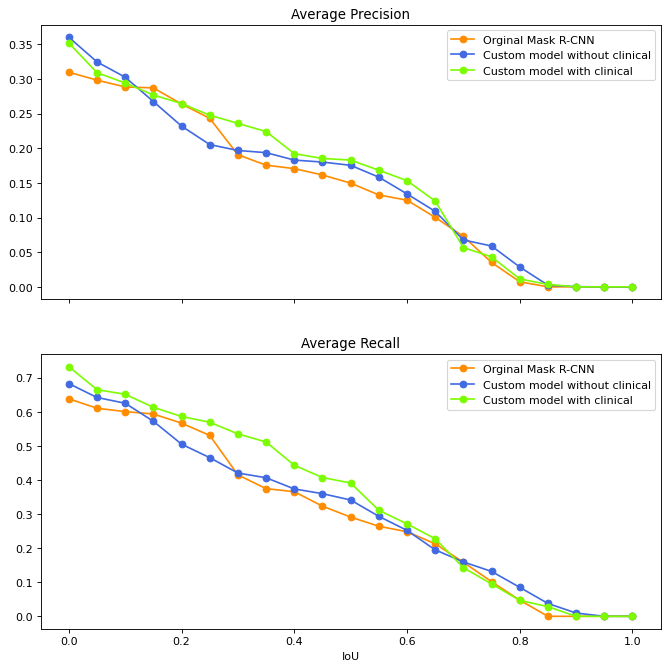

In [5]:
_ = plot_iou_result(model_path_dict, "val")

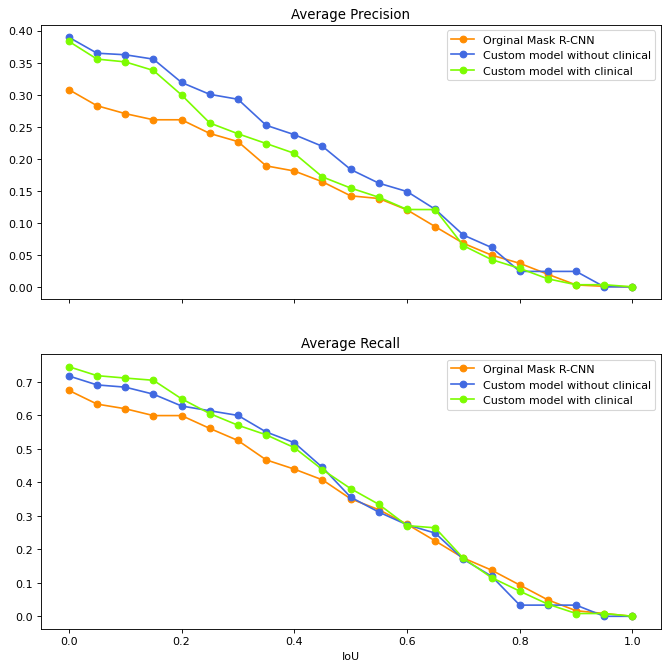

In [6]:
_ = plot_iou_result(model_path_dict, "test")

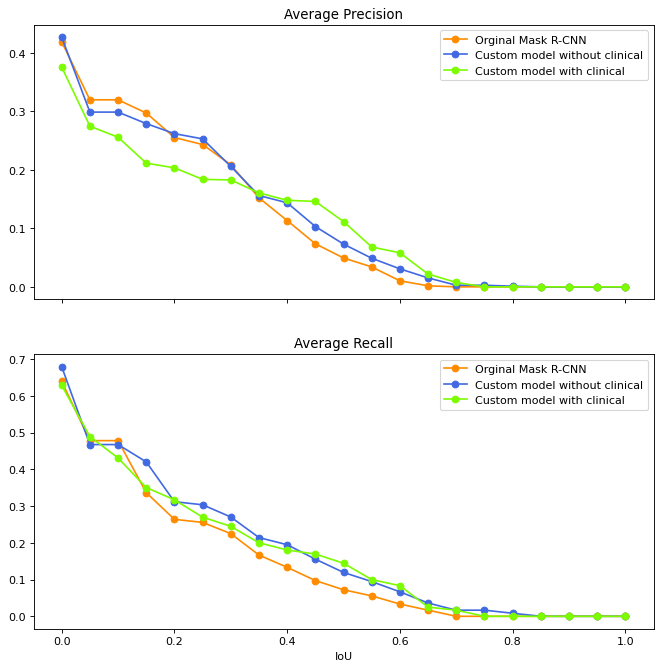

In [7]:
_ = plot_iou_result(model_path_dict, "our")